#### Simple neural network in plain Python
This notebook implements a simple neural network architecture that can map $2$ dimensional input vectors onto binary output values. Our network will have $2$ input neurons, one hidden layer with $6$ hidden neurons and an output layer with $1$ output neuron.

We will represent the architecture by means of the weight matrices between the layers. In our example, the weight matrix between the input and hidden layer will be denoted as $W_h$, the weight matrix between the hidden and output layer as $W_o$. In addition to the weights connecting the neurons, each hidden and output neuron will have a bias weight with a constant input of $+1$.

Our training set consists of $m = 750$ examples. Therefore, we will have the following matrix shapes:

Training set shape: $X = (750, 2)$
Targets shape: $Y = (750, 1)$
$W_h$ shape: $(n_{features}, n_{hidden}) = (2, 6)$
$b_h$ shape (bias vector): $(1, n_{hidden}) = (1, 6)$
$W_o$ shape: $(n_{hidden}, n_{outputs}) = (6, 1)$
$b_o$ shape (bias vector): $(1, n_{outputs}) = (1, 1)$
caption

Loss Function
We will use the same loss function as in logistic regression:

$$
J(\boldsymbol{w},b) = - \frac{1}{m} \sum_{i=1}^m \Big[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \big(1 - \log(\hat{y}^{(i)})\big) \Big] 
$$
For a classification task with more than two classes, we would use a generalization of this function, namely the categorical cross-entropy.

Training
We will train our network with gradient descent and we will use backpropagation to compute the required partial derivatives. The training procedure has the following steps:

Initialize the parameters (i.e. the weights and biases)
Repeat until convergence:
2.1. Propagate the current input batch forward through the network. To do so, compute the activations and outputs of all hidden and output units.
2.2 Compute the partial derivatives of the loss function with respect to each parameter
2.3 Update the parameters
Forward Pass
We start by computing the activation and output of each unit in our network. To speed up the implementation, we won't do this for each input example individually but for all examples at once, using vectorization. We will use the following notation:

$\boldsymbol{A}_h$: matrix with activations of all hidden units for all training examples
$\boldsymbol{O}_h$: matrix with outputs of all hidden units for all training examples
The hidden neurons will have $\tanh$ as their activation function: $$
\tanh(x) = \frac{sinh(x)}{cosh(x)} = \frac{\exp(x) - exp(-x)}{\exp(x) + exp(-x)}
$$$$
\tanh'(x) = 1 - tanh^2(x)
$$

The output neurons will have the $\textit{sigmoid}$ activation function: $$
\sigma(x) = \frac{1}{1 + \exp(-x)}
$$$$
\sigma'(x) = 1 - (1 + \sigma(x))
$$

The activations and outputs can then be computed as follows ($\cdot$ denotes the dot product):

$$
\boldsymbol{A}_h = \boldsymbol{X} \cdot \boldsymbol{W}_h + \boldsymbol{b}_h, \text{shape: } (750, 6)
$$$$
\boldsymbol{O}_h = \sigma(\boldsymbol{A}_h), \text{shape: } (750, 6)
$$$$
\boldsymbol{A}_o = \boldsymbol{O}_h \cdot \boldsymbol{W}_o + b_o, \text{shape: } (750, 1)
$$$$
\boldsymbol{O}_o = \sigma(\boldsymbol{A}_o), \text{shape: } (750, 1)
$$
Backward pass
To compute the weight updates we need the partial derivatives of the loss function with respect to each unit. I won't give the derivation of these equations here, you will find plenty of good explanations on other websites (for example here).

For the output neurons, the gradients are given by (matrix notation):

$\frac{\partial L}{\partial \boldsymbol{A}_o} = d\boldsymbol{A}_o = (\boldsymbol{O}_o - \boldsymbol{Y})$

$\frac{\partial L}{\partial \boldsymbol{W}_o} = \frac{1}{m} (\boldsymbol{O}_h^T \cdot d\boldsymbol{A}_o)$

$\frac{\partial L}{\partial \boldsymbol{b}_o} = \frac{1}{m} \sum d\boldsymbol{A}_o$

For the weight matrix between input and hidden layer we have:
$\frac{\partial L}{\partial \boldsymbol{A}_h} = d\boldsymbol{A}_h = (\boldsymbol{W}_o^T \cdot d\boldsymbol{A}_o) * (1 - \tanh^2 (\boldsymbol{A}_h))$

$\frac{\partial L}{\partial \boldsymbol{W}_h} = \frac{1}{m} (\boldsymbol{X}^T \cdot d\boldsymbol{A}_h)$

$\frac{\partial L}{\partial \boldsymbol{b}_h} = \frac{1}{m} \sum d\boldsymbol{A}_h$

Weight Update
$\boldsymbol{W}_h = \boldsymbol{W}_h - \eta * \frac{\partial L}{\partial \boldsymbol{W}_h}$

$\boldsymbol{b}_h = \boldsymbol{b}_h - \eta * \frac{\partial L}{\partial \boldsymbol{b}_h} $

$\boldsymbol{W}_o = \boldsymbol{W}_o - \eta *   \frac{\partial L}{\partial \boldsymbol{W}_o} $

$\boldsymbol{b}_o = \boldsymbol{b}_o - \eta *  \frac{\partial L}{\partial \boldsymbol{b}_o} $

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
np.random.seed(123)

% matplotlib inline

#### Dataset

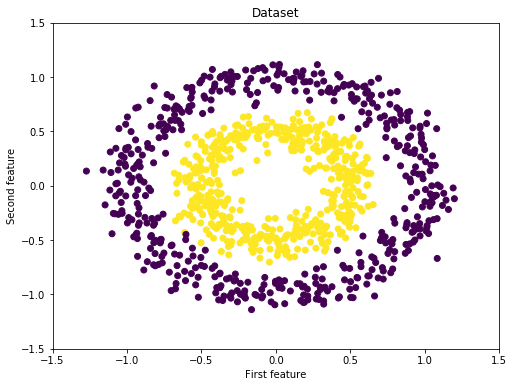

In [2]:
X, y = make_circles(n_samples=1000, factor=0.5, noise=.1)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [3]:
# reshape targets to get column vector with shape (n_samples, 1)
y_true = y[:, np.newaxis]
# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_true)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (750, 2)
Shape y_train: (750, 1)
Shape X_test: (250, 2)
Shape y_test: (250, 1)


#### Neural Network Class
Some parts of this implementation are inspired by the exercises of Andrew Ng's coursera course

In [4]:
class NeuralNet():
    
    def __init__(self, n_inputs, n_outputs, n_hidden):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.hidden = n_hidden

        # Initialize weight matrices and bias vectors
        self.W_h = np.random.randn(self.n_inputs, self.hidden)
        self.b_h = np.zeros((1, self.hidden))
        self.W_o = np.random.randn(self.hidden, self.n_outputs)
        self.b_o = np.zeros((1, self.n_outputs))

    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))

    def forward_pass(self, X):
        """
        Propagates the given input X forward through the net.

        Returns:
            A_h: matrix with activations of all hidden neurons for all input examples
            O_h: matrix with outputs of all hidden neurons for all input examples
            A_o: matrix with activations of all output neurons for all input examples
            O_o: matrix with outputs of all output neurons for all input examples
        """
        # Compute activations and outputs of hidden units
        A_h = np.dot(X, self.W_h) + self.b_h
        O_h = np.tanh(A_h)

        # Compute activations and outputs of output units
        A_o = np.dot(O_h, self.W_o) + self.b_o
        O_o = self.sigmoid(A_o)

        outputs = {
                "A_h": A_h,
                "A_o": A_o,
                "O_h": O_h,
                "O_o": O_o,
                }

        return outputs


    def cost(self, y_true, y_predict, n_samples):
        """
        Computes and returns the cost over all examples
        """
        # same cost function as in logistic regression
        cost = (- 1 / n_samples) * np.sum(y_true * np.log(y_predict) + (1 - y_true) * (np.log(1 - y_predict)))
        cost = np.squeeze(cost)
        assert isinstance(cost, float)

        return cost

    def backward_pass(self,  X, Y, n_samples, outputs):
        """
        Propagates the errors backward through the net.

        Returns:
            dW_h: partial derivatives of loss function w.r.t hidden weights
            db_h: partial derivatives of loss function w.r.t hidden bias
            dW_o: partial derivatives of loss function w.r.t output weights
            db_o: partial derivatives of loss function w.r.t output bias
        """

        dA_o = (outputs["O_o"] - Y)
        dW_o = (1 / n_samples) * np.dot(outputs["O_h"].T, dA_o)
        db_o = (1 / n_samples) * np.sum(dA_o)

        dA_h = (np.dot(dA_o, self.W_o.T)) * (1 - np.power(outputs["O_h"], 2))
        dW_h = (1 / n_samples) * np.dot(X.T, dA_h)
        db_h = (1 / n_samples) * np.sum(dA_h)

        gradients = {
                "dW_o": dW_o,
                "db_o": db_o,
                "dW_h": dW_h,
                "db_h": db_h,
                }

        return gradients

    def update_weights(self, gradients, eta):
        """
        Updates the model parameters using a fixed learning rate
        """
        self.W_o = self.W_o - eta * gradients["dW_o"]
        self.W_h = self.W_h - eta * gradients["dW_h"]
        self.b_o = self.b_o - eta * gradients["db_o"]
        self.b_h = self.b_h - eta * gradients["db_h"]

    def train(self, X, y, n_iters=500, eta=0.3):
        """
        Trains the neural net on the given input data
        """
        n_samples, _ = X.shape

        for i in range(n_iters):
            outputs = self.forward_pass(X)
            cost = self.cost(y, outputs["O_o"], n_samples=n_samples)
            gradients = self.backward_pass(X, y, n_samples, outputs)

            if i % 100 == 0:
                print(f'Cost at iteration {i}: {np.round(cost, 4)}')

            self.update_weights(gradients, eta)


    def predict(self, X):
        """
        Computes and returns network predictions for given dataset
        """
        outputs = self.forward_pass(X)
        y_pred = [1 if elem >= 0.5 else 0 for elem in outputs["O_o"]]

        return np.array(y_pred)[:, np.newaxis]

#### Initializing and training the neural network

In [5]:
nn = NeuralNet(n_inputs=2, n_hidden=6, n_outputs=1)
print("Shape of weight matrices and bias vectors:")
print(f'W_h shape: {nn.W_h.shape}')
print(f'b_h shape: {nn.b_h.shape}')
print(f'W_o shape: {nn.W_o.shape}')
print(f'b_o shape: {nn.b_o.shape}')
print()

print("Training:")
nn.train(X_train, y_train, n_iters=2000, eta=0.7)

Shape of weight matrices and bias vectors:
W_h shape: (2, 6)
b_h shape: (1, 6)
W_o shape: (6, 1)
b_o shape: (1, 1)

Training:
Cost at iteration 0: 1.0872
Cost at iteration 100: 0.2723
Cost at iteration 200: 0.1712
Cost at iteration 300: 0.1386
Cost at iteration 400: 0.1208
Cost at iteration 500: 0.1084
Cost at iteration 600: 0.0986
Cost at iteration 700: 0.0907
Cost at iteration 800: 0.0841
Cost at iteration 900: 0.0785
Cost at iteration 1000: 0.0739
Cost at iteration 1100: 0.0699
Cost at iteration 1200: 0.0665
Cost at iteration 1300: 0.0635
Cost at iteration 1400: 0.061
Cost at iteration 1500: 0.0587
Cost at iteration 1600: 0.0566
Cost at iteration 1700: 0.0547
Cost at iteration 1800: 0.0531
Cost at iteration 1900: 0.0515


#### Testing the neural network

In [6]:
n_test_samples, _ = X_test.shape
y_predict = nn.predict(X_test)
print(f"Classification accuracy on test set: {(np.sum(y_predict == y_test)/n_test_samples)*100} %")

Classification accuracy on test set: 98.4 %


#### Visualizing the decision boundary¶
In the lowermost plot we can see which parts of the input space are classified as positive and which are classified as negative by the trained network.

In [9]:
X_temp, y_temp = make_circles(n_samples=60000, noise=.5)
y_predict_temp = nn.predict(X_temp)
y_predict_temp = np.ravel(y_predict_temp)

Text(0.5,1,'Decision boundary')

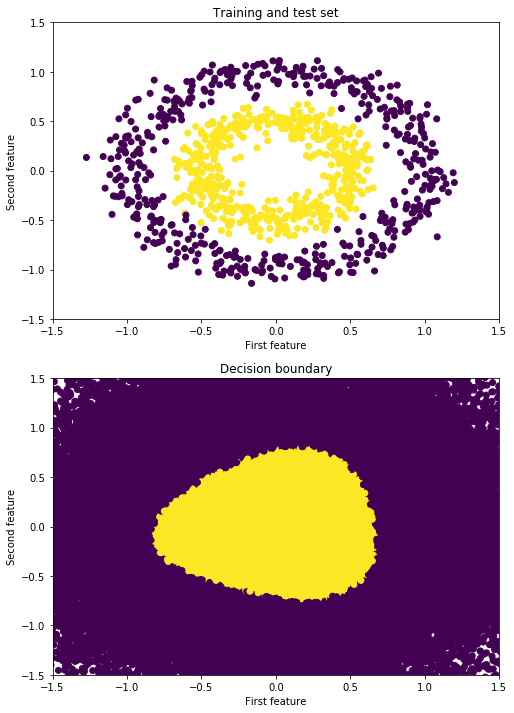

In [10]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(2,1,1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.title("Training and test set")

ax = fig.add_subplot(2,1,2)
plt.scatter(X_temp[:,0], X_temp[:,1], c=y_predict_temp)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.title("Decision boundary")